In [1]:
import os
import pandas as pd
import numpy as np
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import quandl

from scipy import linalg, optimize
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
#from arch import arch_model
from statsmodels.tsa.stattools import adfuller

In [2]:
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
import seaborn as sns
warnings.filterwarnings(action='once')
sns.set()

In [3]:
from IPython.display import Markdown, Latex

In [4]:
def tsplot(y, lags=None, figsize=(10, 8), style='seaborn-bright'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax, linewidth=1.5)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    
    return


### Gaussian white noise

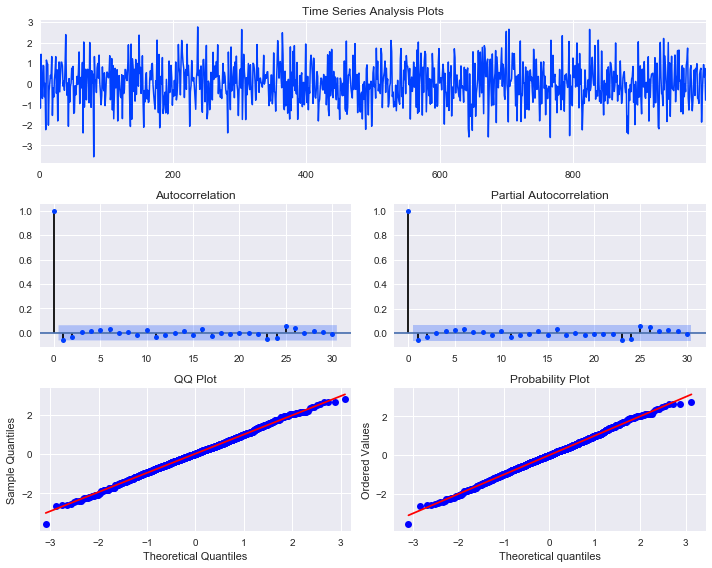

In [5]:
np.random.seed(1234)
randser = np.random.normal(size= 1000)
tsplot(randser, lags = 30)

In [6]:
print('mean :', randser.mean())

mean : 0.01574058215376203


### Random walk process without drift

In [7]:
np.random.seed(150619)
n_samples = 1000

noise = np.random.normal(size = n_samples)
x = noise.copy()

for t in range(n_samples):
    x[t] = x[t-1] + noise[t]

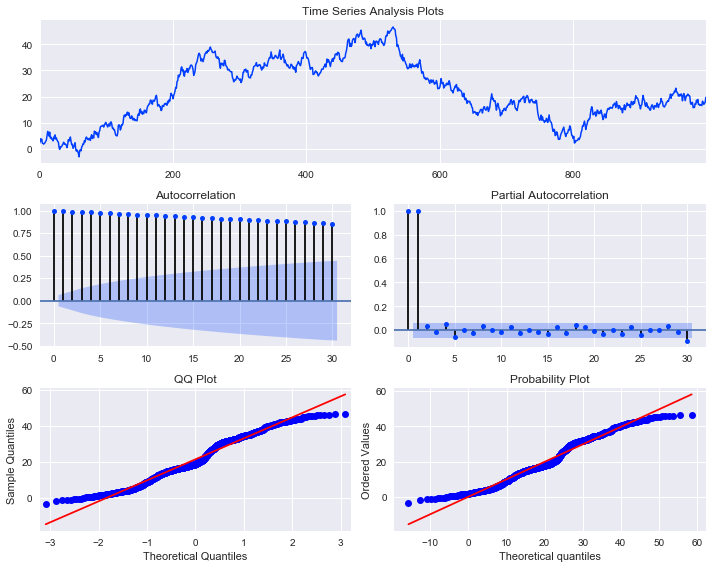

In [8]:
tsplot(x, lags = 30)

### non-stationary series to stationary series

Take first differences anc check for stationarity(ADF Test) and if it is not stationary then do differencing again

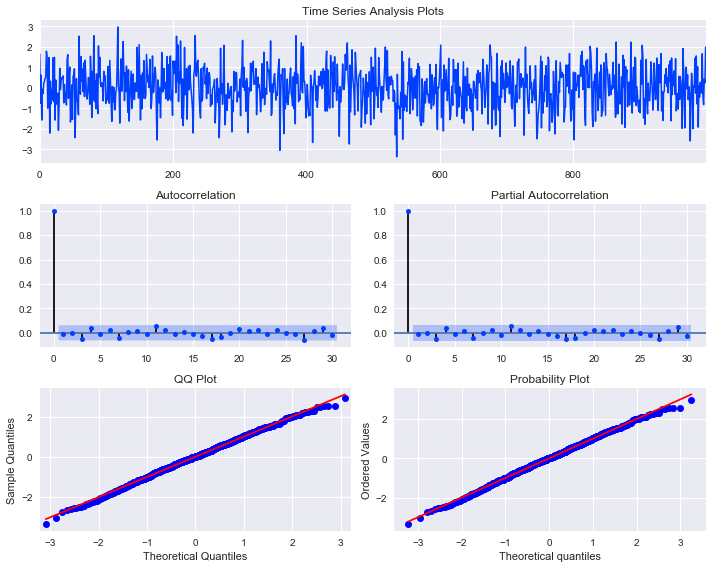

In [9]:
tsplot(np.diff(x), lags = 30)

#### Augmented Dickey Fuller test

In [10]:
dftest = adfuller(np.diff(x), autolag = 'AIC')

In [11]:
dftest

(-31.93356030674761,
 0.0,
 0,
 998,
 {'1%': -3.4369193380671, '10%': -2.56831430323573, '5%': -2.864440383452517},
 2792.235747182278)

#### Random walk for real market data

In [12]:
from datetime import datetime

In [14]:
start = datetime(2018,1,1)
end = datetime(2019,1,1)
aapl = web.DataReader('AAPL', 'yahoo', start, end)

C:\Users\Dell\Anaconda3\lib\site-packages\pandas_datareader\data.py:387: ResourceWarning: unclosed <socket.socket fd=3936, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.10.26.54', 59406), raddr=('106.10.236.40', 443)>
  session=session,


In [15]:
x = pd.DataFrame(aapl['Adj Close'])

In [16]:
x['ret'] = np.log(x['Adj Close']/x['Adj Close'].shift(1))
x.dropna(inplace=True)

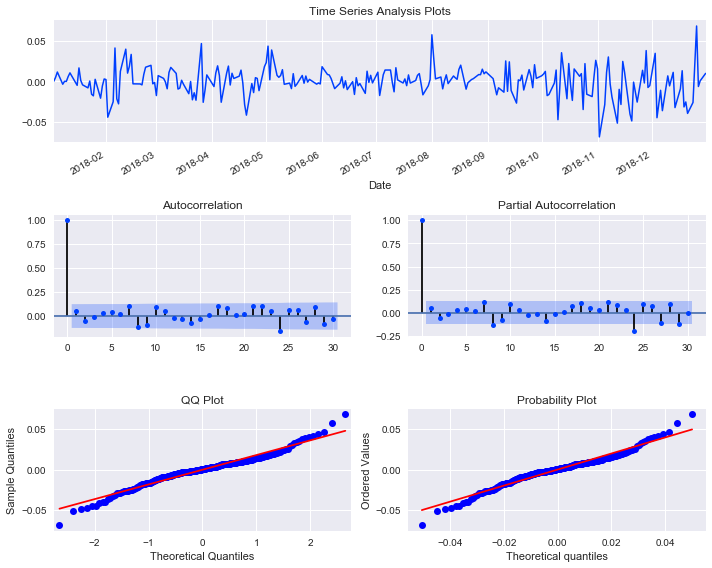

In [17]:
tsplot(x['ret'], lags=30)

In [18]:
dftest_aapl = adfuller(x['ret'], autolag='AIC')
dftest_aapl

(-14.900061809849555,
 1.511745308421726e-27,
 0,
 249,
 {'1%': -3.4568881317725864,
  '10%': -2.5729936189738876,
  '5%': -2.8732185133016057},
 -1192.3791385560785)

In [19]:
dftest_aapl_price = adfuller(x['Adj Close'], autolag='AIC')
dftest_aapl_price

(-1.0155631048260554,
 0.7475457789843436,
 0,
 249,
 {'1%': -3.4568881317725864,
  '10%': -2.5729936189738876,
  '5%': -2.8732185133016057},
 1236.1476812874862)

### Basic ARMA models

#### simulating AR(1) process with phi = 0.75

In [20]:
np.random.seed(19)
n_sample = 1000
phi = 0.75

n = np.random.normal(size=1000)
x = n.copy()

for t in range(n_sample):
    x[t] = phi * x[t-1] + n[t]

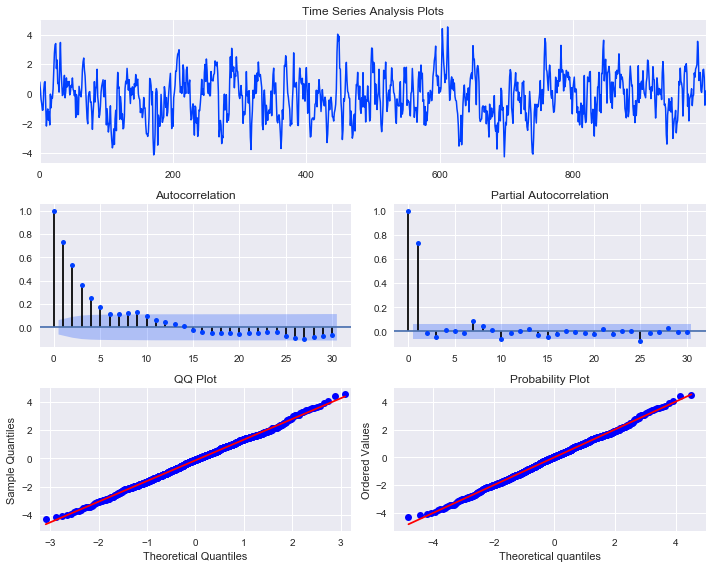

In [21]:
tsplot(x)

### fitting AR(1) model

In [22]:
mdl = sm.tsa.AR(x).fit(maxlag=30, ic = 'aic', trend='nc')
est_order = sm.tsa.AR(x).select_order(maxlag=30, ic = 'aic', trend='nc')

In [23]:
mdl.params

array([0.73726781])

In [24]:
est_order

1

### Simulating and fitting an AR(3) model with phi = [0.4,-0.3,0.25]

In [25]:
n = int(1000)
phi = np.array([0.4,-0.3,0.25])
teta = np.array([0.])

ar = np.r_[1, -phi]
ma = np.r_[1, teta]

ar3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)

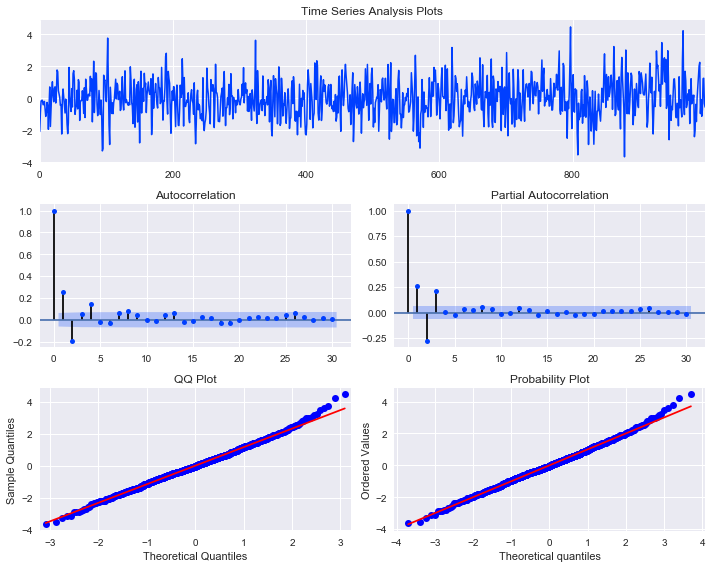

In [26]:
tsplot(ar3, lags=30)

In [27]:
mdl = sm.tsa.AR(ar3).fit(maxlag=30, ic = 'aic', trend='nc')

In [28]:
mdl.params

array([ 0.38518326, -0.34546506,  0.21521001])

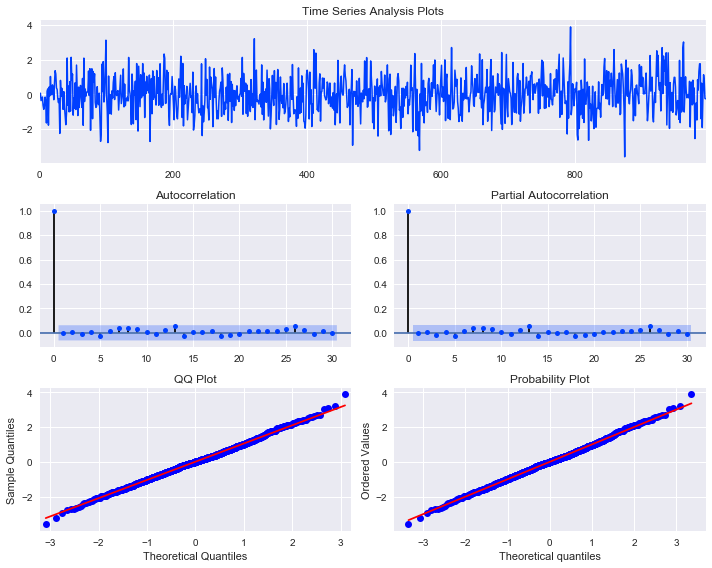

In [29]:
tsplot(mdl.resid, lags=30)

In [30]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _  = jarque_bera(mdl.resid)
if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")

Our residuals are likely normally distributed.


#### Simulating an MA(1) process with teta = 0.75

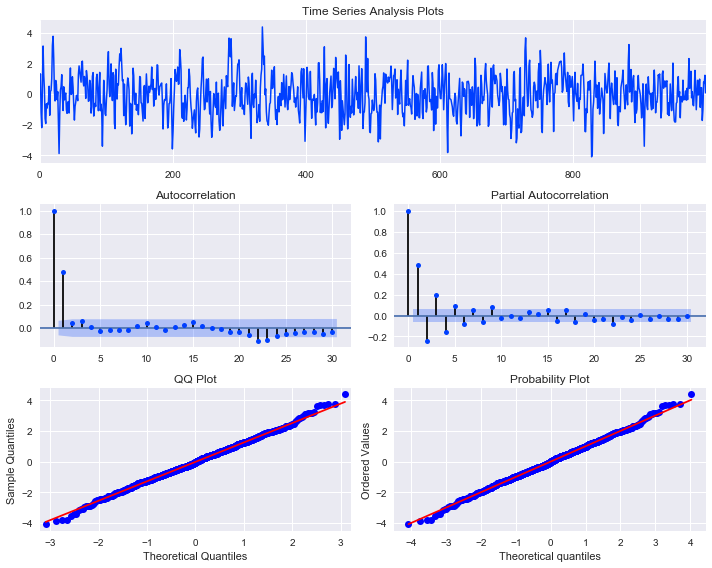

In [31]:
np.random.seed(53)
n = int(1000)

phi = np.array([0.])
teta = np.array([0.75])

ar = np.r_[1, -phi]
ma = np.r_[1, teta]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma1)

### fitting MA(1) model

In [32]:
mdl = sm.tsa.ARMA(ma1, (0,1)).fit(max_lags = 30, method='mle', trend='nc')

In [33]:
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1453.015
Method:                           mle   S.D. of innovations              1.034
Date:                Fri, 10 Jan 2020   AIC                           2910.030
Time:                        18:19:49   BIC                           2919.846
Sample:                             0   HQIC                          2913.761
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.7360      0.025     29.742      0.000       0.687       0.784
                                    Roots                                    
                  Real          Imaginary           M

### simulating and fitting of an ARMA(2,2) with phi = [0.6, -0.25] and teta = [0.5, -0.4]

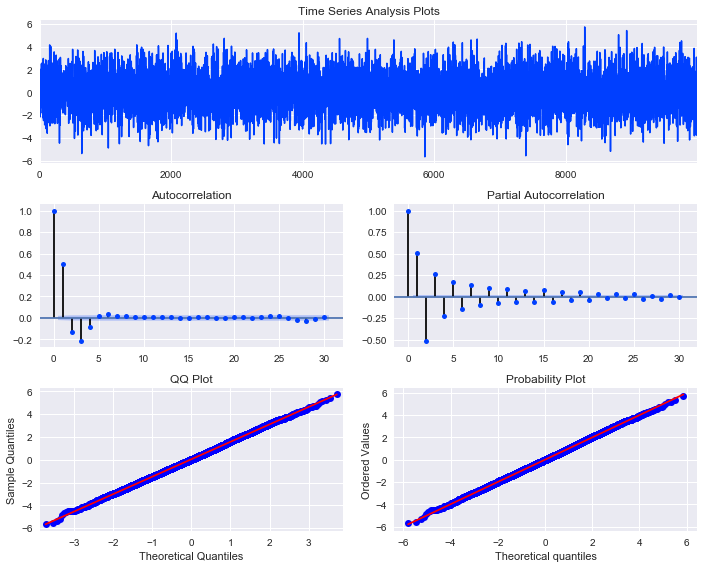

In [34]:
np.random.seed(123)

n = int(10000)
burn = int(n/10)

phi = np.array([0.6,-0.25])
teta = np.array([0.5,-0.4])

ar = np.r_[1, -phi]
ma = np.r_[1, teta]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=30)


In [35]:
mdl = sm.tsa.ARMA(arma22, order = (2,2)).fit( maxlag=30, method='mle', trend='nc', burnin=burn)

In [36]:
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                10000
Model:                     ARMA(2, 2)   Log Likelihood              -14177.051
Method:                           mle   S.D. of innovations              0.999
Date:                Fri, 10 Jan 2020   AIC                          28364.102
Time:                        18:20:04   BIC                          28400.154
Sample:                             0   HQIC                         28376.306
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5768      0.036     15.965      0.000       0.506       0.648
ar.L2.y       -0.2614      0.010    -25.334      0.000      -0.282      -0.241
ma.L1.y        0.5367      0.037     14.527      0.0

In [37]:
from statsmodels.stats.stattools import jarque_bera
score, p_value, _, _ = jarque_bera(mdl.resid)
if p_value < 0.05:
    print('Residuals are not likely normally distributed')
else:
    print('Residuals are likely normally distributed')

Residuals are likely normally distributed


### Fitting an ARMA model to nifty returns

In [38]:
x = pd.DataFrame(np.log(aapl['Adj Close']/aapl['Adj Close'].shift(1)))

In [39]:
x.columns = ['ret']

In [40]:
x.dropna(inplace = True)
x.head()

,ret
Date,
2018-01-03,-0.000174
2018-01-04,0.004634
2018-01-05,0.011321
2018-01-08,-0.003721
2018-01-09,-0.000115


In [41]:
y = x['ret'].values

In [42]:
best_aic = np.inf
best_mdl = None
best_order = None

for i in range(5):
    for j in range(5):
        try:
            temp_mdl = smt.ARMA(y, order = (i,j)).fit(method = 'mle', trend='nc')
            temp_aic = temp_mdl.aic
            if temp_aic < best_aic:
                best_aic = temp_aic
                best_order = (i,j)
                best_mdl = temp_mdl
        except:
            continue

print('best order: ', best_order, 'best_aic: ', best_aic)    

C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Dell\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


best order:  (4, 2) best_aic:  -1294.2386996714438


In [43]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                     ARMA(4, 2)   Log Likelihood                 654.119
Method:                           mle   S.D. of innovations              0.018
Date:                Fri, 10 Jan 2020   AIC                          -1294.239
Time:                        18:20:46   BIC                          -1269.588
Sample:                             0   HQIC                         -1284.318
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        1.3096      0.066     19.915      0.000       1.181       1.438
ar.L2.y       -1.0708      0.104    -10.320      0.000      -1.274      -0.867
ar.L3.y        0.1207      0.105      1.149      0.252      -0.085       0.327
ar.L4.y       -0.0150      0.064     -0.236      0.814      -0.140       0.110
ma.L1.y       -1.2902      0.024    -54.454      0.000      -1.337      -1.244
ma.L2.y        0.9999      0.024     42.537      0.000       0.954       1.046
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6501           -0.8130j            1.0409           -0.1426
AR.2            0.6501           +0.8130j            1.0409            0.1426
AR.3            3.3645           -7.0748j            7.8341           -0.1794
AR.4            3.3645           +7.0748j            7.8341            0.1794
MA.1            0.6452           -0.7641j            1.0000           -0.1384
MA.2            0.6452           +0.7641j            1.0000            0.1384
-----------------------------------------------------------------------------
"""

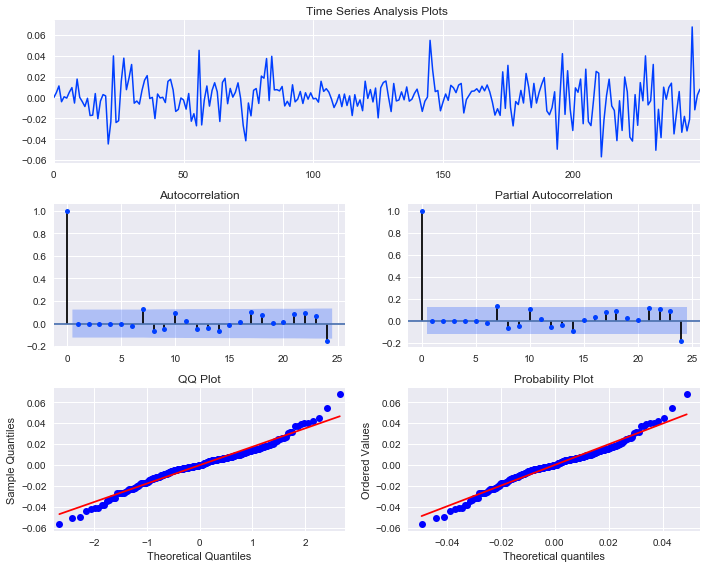

In [44]:
tsplot(best_mdl.resid)

In [45]:
score, pvalue, _, _ = jarque_bera(best_mdl.resid)
if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")

Our residuals are likely not normally distributed.


### Simulating and fitting an ARIMA model

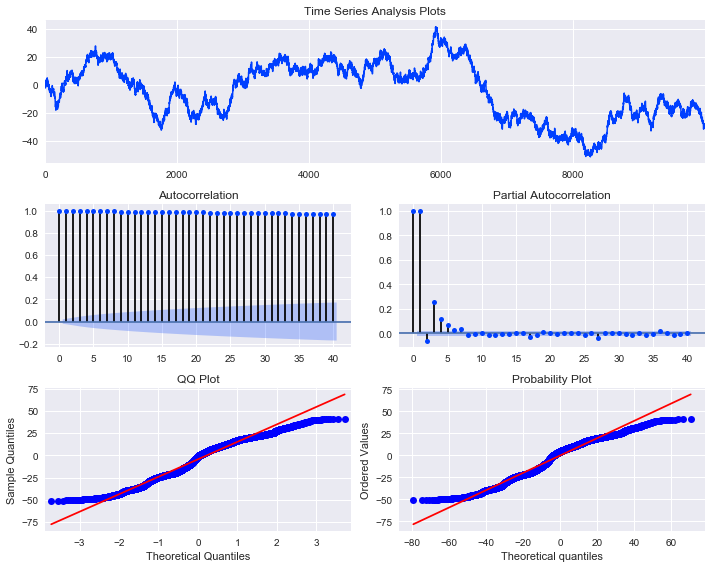

In [46]:
max_lag = 30

n = int(10000)
burn = int(0.2*n)

phi = np.array([0.5, -0.25])
teta = np.array([-0.5])

ar = np.r_[1, -phi]
ma = np.r_[1, teta]

arma21 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
arma211 = arma21.cumsum()
tsplot(arma211)

In [47]:
%%time

best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2)
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(arma211, order=(i, d, j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except:
                continue
            
print("aic : ",best_aic, "| order : ",best_order)

aic :  28264.83970750801 | order :  (2, 1, 1)
Wall time: 1min 41s


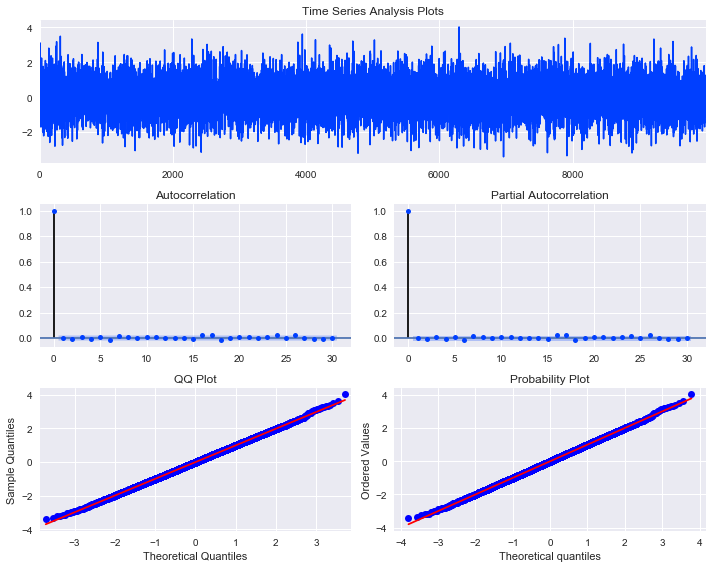

In [48]:
tsplot(best_mdl.resid, lags=30)

In [49]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(best_mdl.resid)
if pvalue < 0.05:
    print("Our residuals are likely not normally distributed.")
else:
    print("Our residuals are likely normally distributed.")

Our residuals are likely normally distributed.


### As we see the model is a near perfect fit, now we'll predict the future data points using this model

In [50]:
n_steps = 21
f, err95, ci95 = best_mdl.forecast(steps=n_steps)

In [51]:
f

array([-30.15801345, -29.79273273, -29.69214487, -29.73847552,
       -29.79167615, -29.80789354, -29.8020021 , -29.79428699,
       -29.79170574, -29.79243478, -29.79354876, -29.79395519,
       -29.79386835, -29.79370821, -29.79364481, -29.79365458,
       -29.79367749, -29.7936873 , -29.79368631, -29.79368304,
       -29.79368154])

### simulating an ARCH(1)

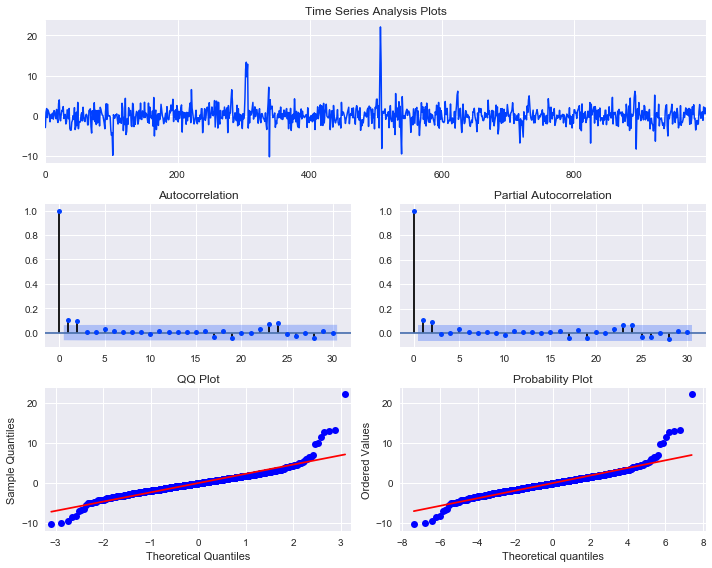

In [54]:
np.random.seed(100)

a = 2
b1 = 0.5

n = 1000

noise = np.random.normal(size=n)
e = noise.copy()

for t in range(n):
    e[t] = noise[t] * np.sqrt(a + b1 * e[t-1]**2)
tsplot(e, lags =30)

C:\Users\Dell\Anaconda3\lib\contextlib.py:159: ResourceWarning: unclosed <socket.socket fd=4104, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('10.10.26.54', 59252), raddr=('119.161.10.12', 443)>
  return _GeneratorContextManager(func, args, kwds)


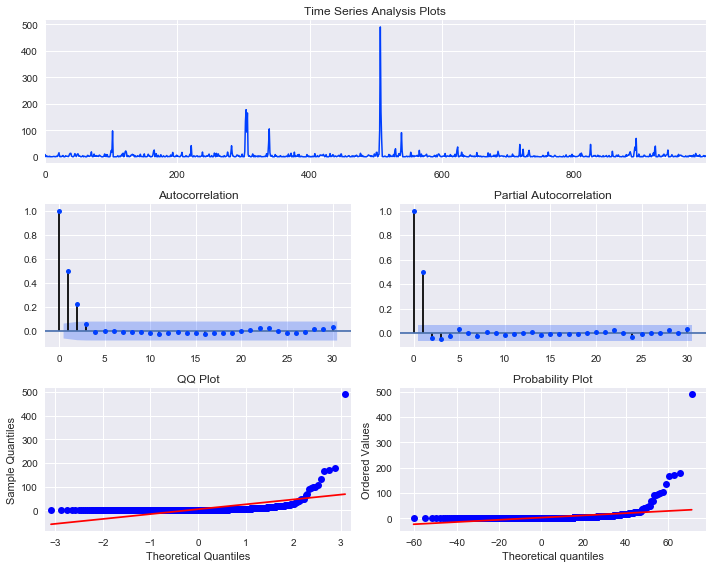

In [55]:
tsplot(e**2, lags=30)

### GARCH(1,1)

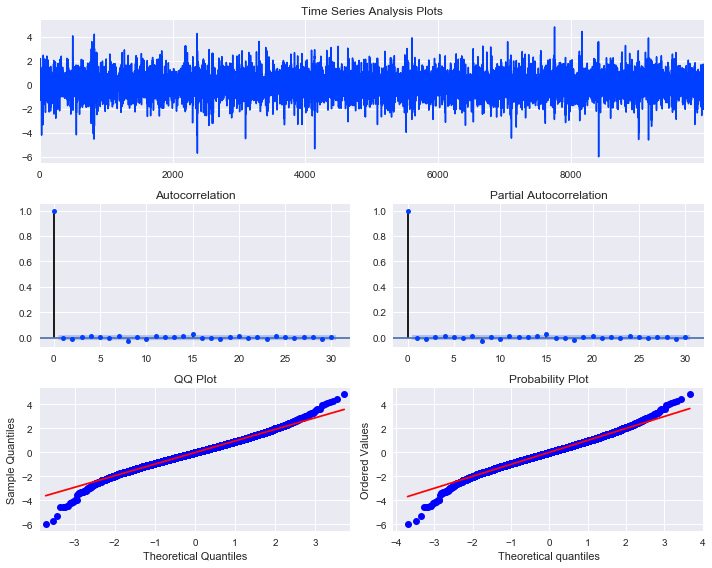

In [56]:
np.random.seed(12)

a = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
noise = np.random.normal(size=n)

e = np.zeros_like(noise)
sig_sq = np.zeros_like(noise)

for t in range(1, len(e)):
    sig_sq[t] = a + b1* e[t-1]**2 + a1 * sig_sq[t-1]
    e[t] = noise[t] * np.sqrt(sig_sq[t])
tsplot(e, lags=30)

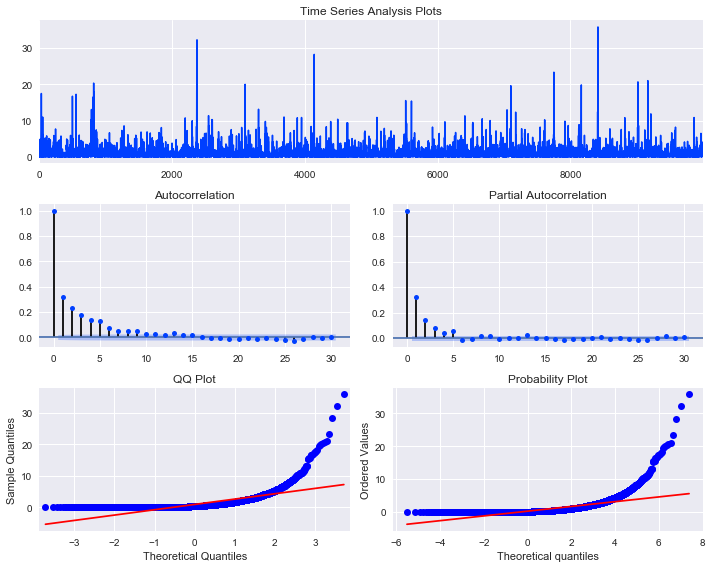

In [57]:
tsplot(e ** 2, lags=30)